# Import Library

In [1]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 4.8 MB/s eta 0:00:00


In [2]:
import os
import shutil
import holidays
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from google.colab import drive

# Library Statistik untuk EDA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Preprocessing & Metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

# Deep Learning (TensorFlow)
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Tuning
import keras_tuner as kt

print("Library berhasil diimpor.")

Library berhasil diimpor.


# Data Preparation

## Load Data

In [3]:
drive.mount('/content/drive')

base_path = '/content/drive/MyDrive/Magang Prima PTKI/data_dummy'

Mounted at /content/drive


In [4]:
# Load Data
transactions_df = pd.read_csv(os.path.join(base_path, 'transactions.csv'))
transaction_details_df = pd.read_csv(os.path.join(base_path, 'transaction_details.csv'))
products_df = pd.read_csv(os.path.join(base_path, 'products.csv'))
stores_df = pd.read_csv(os.path.join(base_path, 'stores.csv'))

## Merging Data

In [5]:
# Merging
df_merged = pd.merge(transactions_df, transaction_details_df, left_on='id', right_on='transactionId')
df_merged = pd.merge(df_merged, products_df[['id', 'productCategoryId']], left_on='productId', right_on='id', suffixes=('', '_prod'))
df_merged = pd.merge(df_merged, stores_df[['id', 'storeTypeId']], left_on='storeId', right_on='id', suffixes=('', '_store'))

In [6]:
# Filter Store ID 6 (Healthcare)
TARGET_STORE_ID = 6
df_healthcare = df_merged[df_merged['storeId'] == TARGET_STORE_ID].copy()
df_healthcare['transactionDate'] = pd.to_datetime(df_healthcare['transactionDate'])

## Data Cleaning

In [7]:
# Agregasi Harian
time_series_hc = df_healthcare.groupby(df_healthcare['transactionDate'].dt.date)['subtotal'].sum().reset_index()
time_series_hc.columns = ['date', 'revenue']
time_series_hc['date'] = pd.to_datetime(time_series_hc['date'])
time_series_hc.set_index('date', inplace=True)

In [8]:
# Reindex agar tanggal berurutan
all_days = pd.date_range(start=time_series_hc.index.min(), end=time_series_hc.index.max(), freq='D')
time_series_hc = time_series_hc.reindex(all_days, fill_value=0)

In [9]:
# Handling Outliers (Clipping)
Q1 = time_series_hc['revenue'].quantile(0.25)
Q3 = time_series_hc['revenue'].quantile(0.75)
IQR = Q3 - Q1
time_series_hc['revenue_clean'] = time_series_hc['revenue'].clip(lower=Q1 - 1.5*IQR, upper=Q3 + 1.5*IQR)

print(f"Data Healthcare (Store {TARGET_STORE_ID}) berhasil dibersihkan.")

Data Healthcare (Store 6) berhasil dibersihkan.


# Exploratory Data Analysis (EDA)

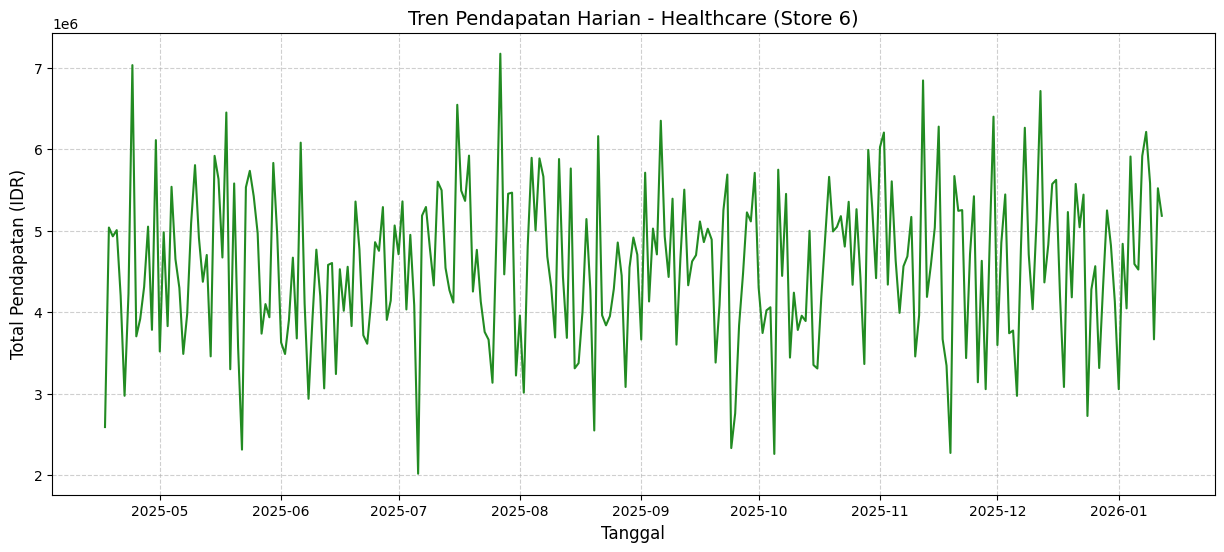

In [10]:
# 1. Tren Pendapatan Harian
plt.figure(figsize=(15, 6))
plt.plot(time_series_hc.index, time_series_hc['revenue_clean'], color='forestgreen', linewidth=1.5)
plt.title('Tren Pendapatan Harian - Healthcare (Store 6)', fontsize=14)
plt.xlabel('Tanggal', fontsize=12)
plt.ylabel('Total Pendapatan (IDR)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

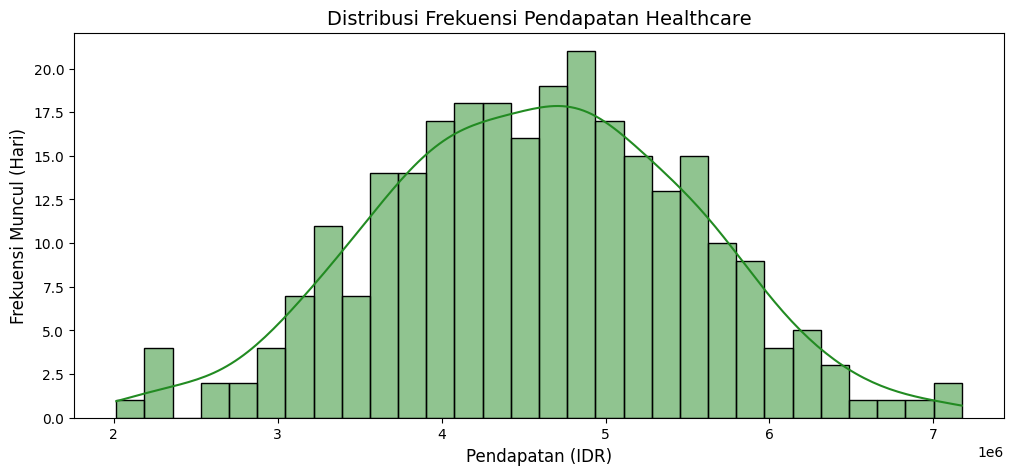

In [11]:
# 2. Distribusi Pendapatan
plt.figure(figsize=(12, 5))
sns.histplot(time_series_hc['revenue_clean'], kde=True, color='forestgreen', bins=30)
plt.title('Distribusi Frekuensi Pendapatan Healthcare', fontsize=14)
plt.xlabel('Pendapatan (IDR)', fontsize=12)
plt.ylabel('Frekuensi Muncul (Hari)', fontsize=12)
plt.show()

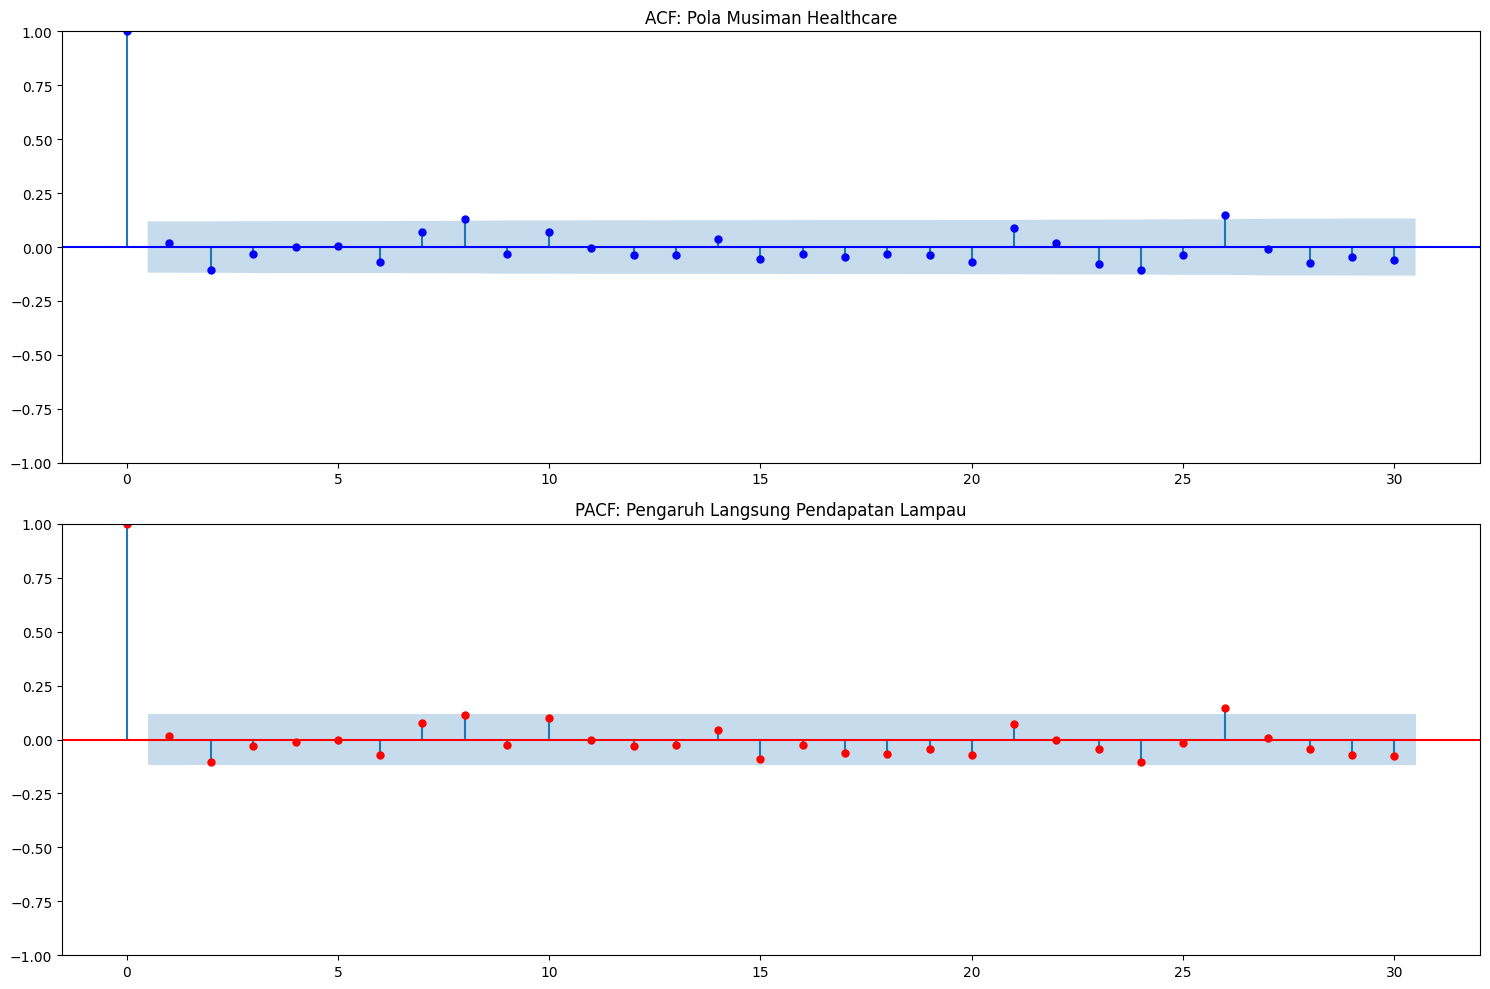

In [12]:
# 3. ACF & PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
plot_acf(time_series_hc['revenue_clean'], lags=30, ax=ax1, color='blue')
ax1.set_title('ACF: Pola Musiman Healthcare', fontsize=12)
plot_pacf(time_series_hc['revenue_clean'], lags=30, ax=ax2, color='red')
ax2.set_title('PACF: Pengaruh Langsung Pendapatan Lampau', fontsize=12)
plt.tight_layout()
plt.show()

/tmp/ipython-input-3802529951.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='day_name', y='revenue_clean', data=time_series_hc, order=order, palette='viridis')


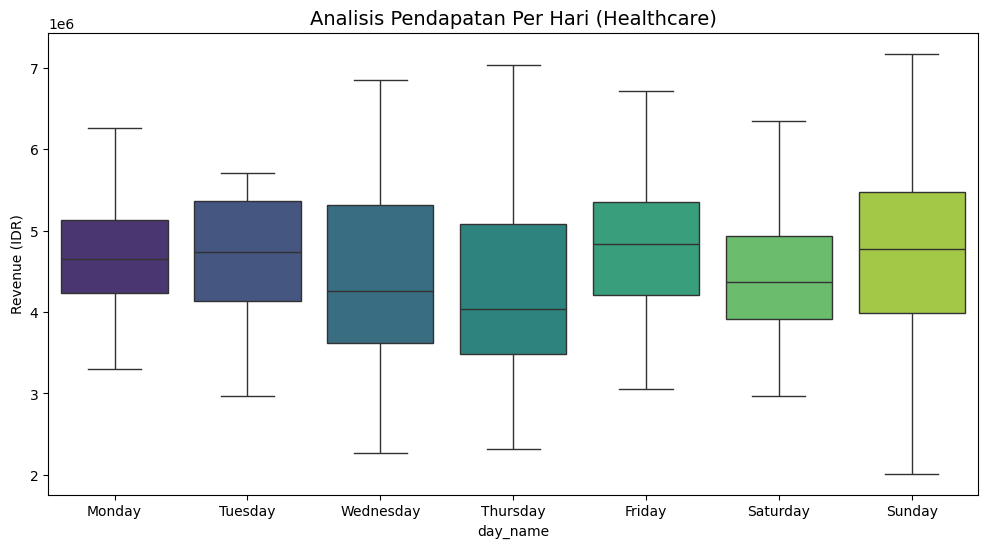

In [13]:
# 4. Boxplot Hari dalam Seminggu
time_series_hc['day_name'] = time_series_hc.index.day_name()
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(12, 6))
sns.boxplot(x='day_name', y='revenue_clean', data=time_series_hc, order=order, palette='viridis')
plt.title('Analisis Pendapatan Per Hari (Healthcare)', fontsize=14)
plt.ylabel('Revenue (IDR)')
plt.show()

In [14]:
# 5. Ringkasan Statistik
stats = time_series_hc['revenue_clean'].describe()
print("="*45)
print("   RINGKASAN STATISTIK PENDAPATAN HEALTHCARE")
print("="*45)
print(f"Rata-rata Harian    : Rp {stats['mean']:,.2f}")
print(f"Standar Deviasi     : Rp {stats['std']:,.2f}")
print(f"Median (P50)        : Rp {stats['50%']:,.2f}")
print(f"Maksimum            : Rp {stats['max']:,.2f}")
print("="*45)

   RINGKASAN STATISTIK PENDAPATAN HEALTHCARE
Rata-rata Harian    : Rp 4,572,077.49
Standar Deviasi     : Rp 952,527.65
Median (P50)        : Rp 4,603,000.00
Maksimum            : Rp 7,173,000.00


# Preprocessing Data

## Feature Engineering

(Menambah Konteks Waktu)

In [15]:
# 1. Feature Engineering
id_holidays = holidays.Indonesia(years=[2025, 2026])
time_series_hc['is_holiday'] = time_series_hc.index.strftime('%Y-%m-%d').isin(id_holidays).astype(int)
time_series_hc['is_payday'] = time_series_hc.index.day.map(lambda x: 1 if x >= 25 or x <= 5 else 0)
time_series_hc['is_weekend'] = time_series_hc.index.weekday.map(lambda x: 1 if x >= 5 else 0)

In [16]:
# Menambahkan Lag 1-7 untuk memori jangka pendek harian
for i in range(1, 8):
    time_series_hc[f'lag_{i}'] = time_series_hc['revenue_clean'].shift(i)

In [17]:
# Rolling average untuk menangkap tren mingguan
time_series_hc['rolling_avg_7d'] = time_series_hc['revenue_clean'].rolling(window=7).mean()

In [18]:
# Update Feature Engineering (Menambah Day of Month)
time_series_hc['day_of_month'] = time_series_hc.index.day

In [19]:
# Drop NaN
time_series_hc.dropna(inplace=True)

## Scaling

In [20]:
# 2. Definisikan X dan y
features = [f'lag_{i}' for i in range(1, 8)] + ['is_holiday', 'is_payday', 'is_weekend', 'rolling_avg_7d', 'day_of_month']
X_raw = time_series_hc[features]
y_raw = time_series_hc['revenue_clean']

In [21]:
# 3. Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw.values.reshape(-1, 1))

In [22]:
# 4. Reshaping ke 3D
X_final = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
y_final = y_scaled

## Splitting Data (Train & Test)

In [23]:
# 5. Split Data (80/20)
train_size = int(len(X_final) * 0.8)
X_train, X_test = X_final[:train_size], X_final[train_size:]
y_train, y_test = y_final[:train_size], y_final[train_size:]

print(f"Preprocessing Healthcare Selesai. Train size: {len(X_train)} hari.")

Preprocessing Healthcare Selesai. Train size: 211 hari.


# Modeling

In [24]:
def model_builder(hp):
    model = Sequential()

    # CNN Layer
    model.add(Conv1D(
        filters=hp.Int("conv_filters", 32, 128, 16),
        kernel_size=1, activation='relu',
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(MaxPooling1D(pool_size=1))

    # Bi-LSTM Layer
    model.add(Bidirectional(LSTM(units=hp.Int("bilstm_units", 64, 256, 32), return_sequences=True)))
    model.add(Dropout(hp.Float("dropout_1", 0.1, 0.4, 0.1)))

    # LSTM 2
    model.add(LSTM(units=hp.Int("lstm_units", 32, 128, 32), return_sequences=False))

    model.add(Dense(hp.Int("dense_units", 32, 128, 32), activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Reset Tuner Khusus Healthcare
tuner_path = 'tuner_dir/healthcare_tuning'
if os.path.exists(tuner_path):
    shutil.rmtree(tuner_path)

tuner = kt.RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=10,
    directory='tuner_dir',
    project_name='healthcare_tuning',
    overwrite=True
)

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

print("Memulai Hyperparameter Tuning untuk Healthcare...")
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stop], verbose=1)

# Ambil Model Terbaik
best_model = tuner.get_best_models(num_models=1)[0]
print("\nTuning Selesai. Arsitektur model terbaik dipilih.")
best_model.summary()

Trial 10 Complete [00h 00m 14s]
val_loss: 0.03231988847255707

Best val_loss So Far: 0.01892179250717163
Total elapsed time: 00h 02m 09s

Tuning Selesai. Arsitektur model terbaik dipilih.


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 96)          │         1,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 96)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 1, 384)         │       443,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 384)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 96)             │       184,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 639,265 (2.44 MB)

 Trainable params: 639,265 (2.44 MB)

 Non-trainable params: 0 (0.00 B)

# Evaluation & Visualization

In [25]:
# 1. Pelatihan Akhir Model Terbaik
print("Melatih model akhir dengan arsitektur terpilih...")
history = best_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Melatih model akhir dengan arsitektur terpilih...
Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - loss: 0.0246 - mae: 0.1264 - val_loss: 0.0320 - val_mae: 0.1466
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0150 - mae: 0.0974 - val_loss: 0.0214 - val_mae: 0.1096
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0120 - mae: 0.0839 - val_loss: 0.0199 - val_mae: 0.1069
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0084 - mae: 0.0724 - val_loss: 0.0194 - val_mae: 0.1067
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0093 - mae: 0.0749 - val_loss: 0.0179 - val_mae: 0.0956
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0078 - mae: 0.0707 - val_loss: 0.0174 - val_mae: 0.0970
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0087 - mae: 0.0755 - val_loss: 0.0213 - val_mae: 0.1151
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0105 - mae: 0.0838 - val_loss: 0.0185 - val_mae: 0.1057
Epoch 

In [26]:
# 2. Melakukan Prediksi pada Data Uji
y_pred_scaled = best_model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 470ms/step


In [27]:
# 3. Inverse Scale (Kembalikan ke nilai Rupiah asli)
y_pred = scaler_y.inverse_transform(y_pred_scaled).ravel()
y_actual = scaler_y.inverse_transform(y_test).ravel()

In [28]:
# 4. Hitung Metrik Evaluasi (MAE, MAPE, dan R2-SCORE)
mae = mean_absolute_error(y_actual, y_pred)
mape = mean_absolute_percentage_error(y_actual, y_pred) * 100
r2 = r2_score(y_actual, y_pred)

In [29]:
print("="*45)
print("   HASIL EVALUASI MODEL HEALTHCARE (STORE 6)")
print("="*45)
print(f"Mean Absolute Error (MAE)  : Rp {mae:,.2f}")
print(f"Mean Absolute Percentage Error (MAPE) : {mape:.2f}%")
print(f"R2-Score (Goodness of Fit) : {r2:.4f}") # Menampilkan R2
print("="*45)

   HASIL EVALUASI MODEL HEALTHCARE (STORE 6)
Mean Absolute Error (MAE)  : Rp 205,908.12
Mean Absolute Percentage Error (MAPE) : 4.64%
R2-Score (Goodness of Fit) : 0.9210


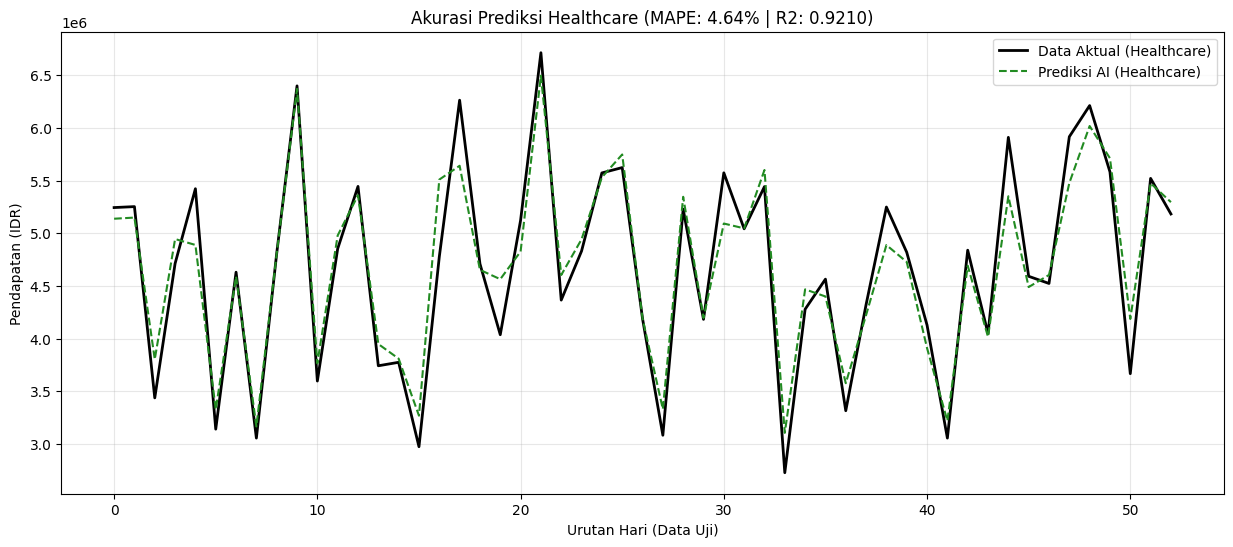

In [30]:
# 5. Visualisasi Prediksi vs Aktual
plt.figure(figsize=(15, 6))
plt.plot(y_actual, label='Data Aktual (Healthcare)', color='black', linewidth=2)
plt.plot(y_pred, label='Prediksi AI (Healthcare)', color='forestgreen', linestyle='--')
plt.title(f'Akurasi Prediksi Healthcare (MAPE: {mape:.2f}% | R2: {r2:.4f})')
plt.ylabel('Pendapatan (IDR)')
plt.xlabel('Urutan Hari (Data Uji)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

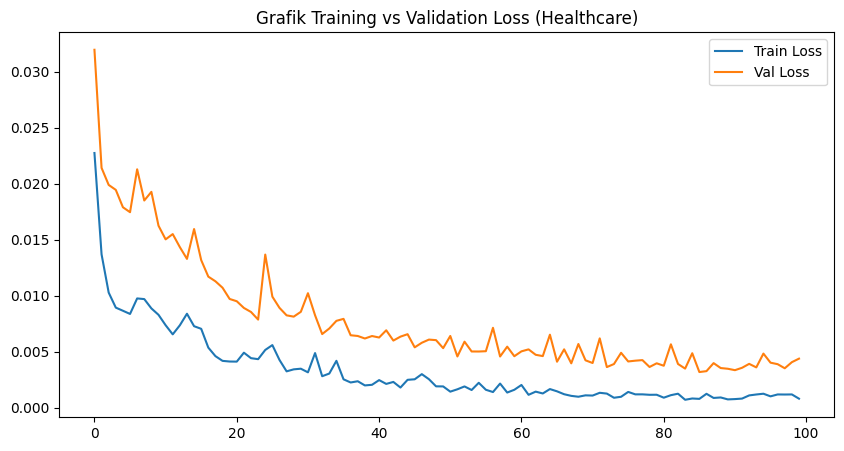

In [31]:
# 6. Visualisasi Training Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Grafik Training vs Validation Loss (Healthcare)')
plt.legend()
plt.show()

# Save Model

In [32]:
# Simpan Model & Scaler Healthcare
model_path = '/content/drive/MyDrive/Magang Prima PTKI/models/healthcare/model_healthcare_store_6.keras'
os.makedirs(os.path.dirname(model_path), exist_ok=True)
best_model.save(model_path)
joblib.dump(scaler_X, '/content/drive/MyDrive/Magang Prima PTKI/models/healthcare/scaler_X_healthcare.pkl')
joblib.dump(scaler_y, '/content/drive/MyDrive/Magang Prima PTKI/models/healthcare/scaler_y_healthcare.pkl')

['/content/drive/MyDrive/Magang Prima PTKI/models/healthcare/scaler_y_healthcare.pkl']

# Kode Inference Dengan Analisis Bisnis

In [33]:
# 1. Load Model & Scaler
model = load_model('/content/drive/MyDrive/Magang Prima PTKI/models/healthcare/model_healthcare_store_6.keras')
scaler_X = joblib.load('/content/drive/MyDrive/Magang Prima PTKI/models/healthcare/scaler_X_healthcare.pkl')
scaler_y = joblib.load('/content/drive/MyDrive/Magang Prima PTKI/models/healthcare/scaler_y_healthcare.pkl')

In [34]:
def get_forecast_7_days_stabilized(model, df_historical, scaler_X, scaler_y):
    # Ambil data 7 hari terakhir
    current_lags = df_historical['revenue_clean'].tail(7).tolist()

    # Hitung rata-rata per hari dalam seminggu (untuk Rem/Stabilizer)
    # Ini adalah logika senior: Menggunakan pola historis mingguan
    weekly_pattern = df_historical.groupby(df_historical.index.dayofweek)['revenue_clean'].mean()

    predictions = []
    dates = []
    last_date = df_historical.index[-1]
    id_holidays = holidays.Indonesia(years=[last_date.year, last_date.year + 1])

    print("="*60)
    print(f"   PREDIKSI OPERASIONAL TERSTABILISASI (7 HARI)")
    print(f"   (Batas Data: {last_date.strftime('%d %b %Y')})")
    print("="*60)

    for i in range(1, 8):
        current_date = last_date + timedelta(days=i)
        day_idx = current_date.weekday()

        # Fitur Engineering
        is_holiday = 1 if current_date.strftime('%Y-%m-%d') in id_holidays else 0
        is_payday = 1 if current_date.day >= 25 or current_date.day <= 5 else 0
        is_weekend = 1 if day_idx >= 5 else 0
        rolling_avg = np.mean(current_lags)
        day_of_month = current_date.day

        # Susun fitur (12 fitur)
        input_row = current_lags + [is_holiday, is_payday, is_weekend, rolling_avg, day_of_month]

        # Scaling & Prediksi
        input_scaled = scaler_X.transform([input_row])
        input_final = input_scaled.reshape((1, 1, len(features)))
        pred_scaled = model.predict(input_final, verbose=0)
        raw_pred = scaler_y.inverse_transform(pred_scaled)[0][0]

        # --- LOGIKA "REM" (STABILIZER) ---
        # Kita campur hasil AI (70%) dengan rata-rata historis hari tersebut (30%)
        # Ini mencegah model melompat terlalu jauh dari kenyataan historis
        avg_hist_day = weekly_pattern[day_idx]
        stabilized_pred = (raw_pred * 0.7) + (avg_hist_day * 0.3)

        # Clipping: Jangan biarkan melebihi 120% dari nilai maksimum historis
        max_limit = df_historical['revenue_clean'].max() * 1.2
        final_pred = min(stabilized_pred, max_limit)

        predictions.append(final_pred)
        dates.append(current_date)

        # Update Lags untuk iterasi berikutnya
        current_lags.pop(0)
        current_lags.append(final_pred)

        status = "RAMAI" if final_pred > stats['mean'] * 1.1 else "NORMAL"
        print(f"{current_date.strftime('%A, %d %b')}: Rp {final_pred:,.0f} | {status}")

    return pd.DataFrame({'date': dates, 'pred_revenue': predictions}).set_index('date')

In [35]:
# Jalankan Proyeksi Baru
forecast_results_stable = get_forecast_7_days_stabilized(best_model, time_series_hc, scaler_X, scaler_y)

   PREDIKSI OPERASIONAL TERSTABILISASI (7 HARI)
   (Batas Data: 12 Jan 2026)
Tuesday, 13 Jan: Rp 4,965,281 | NORMAL
Wednesday, 14 Jan: Rp 5,007,010 | NORMAL


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Thursday, 15 Jan: Rp 4,851,329 | NORMAL
Friday, 16 Jan: Rp 5,361,483 | RAMAI
Saturday, 17 Jan: Rp 4,861,648 | NORMAL


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Sunday, 18 Jan: Rp 4,818,876 | NORMAL
Monday, 19 Jan: Rp 4,763,679 | NORMAL


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


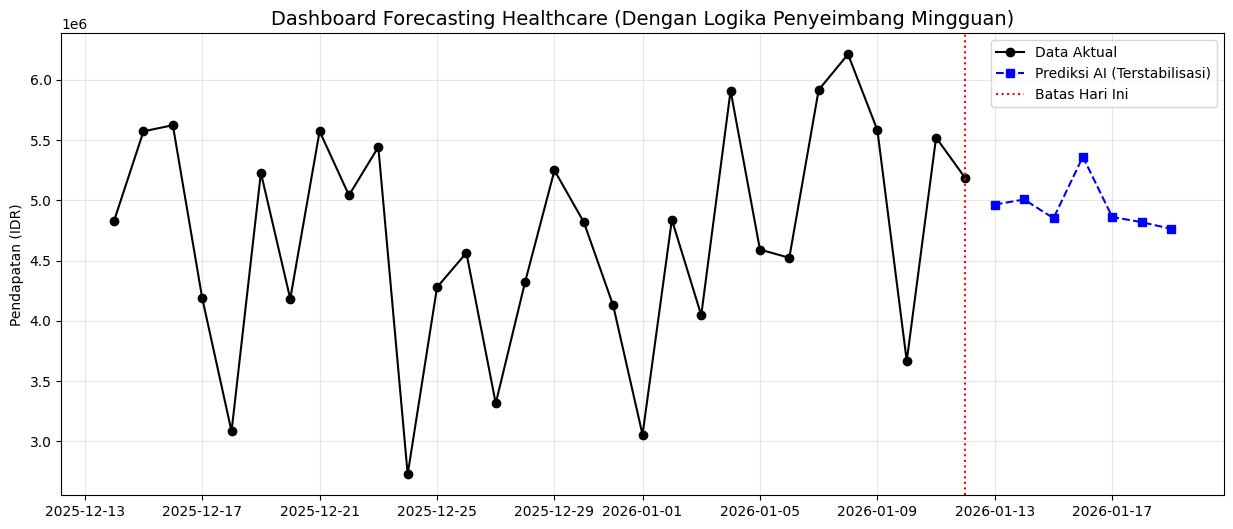

In [36]:
# Visualisasi
plt.figure(figsize=(15, 6))
hist_data = time_series_hc.tail(30)
plt.plot(hist_data.index, hist_data['revenue_clean'], label='Data Aktual', color='black', marker='o')
plt.plot(forecast_results_stable.index, forecast_results_stable['pred_revenue'],
         label='Prediksi AI (Terstabilisasi)', color='blue', linestyle='--', marker='s')

plt.axvline(x=hist_data.index[-1], color='red', linestyle=':', label='Batas Hari Ini')
plt.title('Dashboard Forecasting Healthcare (Dengan Logika Penyeimbang Mingguan)', fontsize=14)
plt.ylabel('Pendapatan (IDR)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()